<a href="https://colab.research.google.com/github/venkatesh-eranti/clustering_cricket-data/blob/main/clustering_cricket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading data and understanding the data

## importing the required librariers

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

loading the data

In [1]:
data='https://raw.githubusercontent.com/venkatesh-eranti/clustering_cricket/main/Cricket.csv'

In [4]:
df=pd.read_csv(data,encoding = 'unicode_escape')
df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


## checking data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  79 non-null     object 
 1   Span    79 non-null     object 
 2   Mat     79 non-null     int64  
 3   Inns    79 non-null     int64  
 4   NO      79 non-null     int64  
 5   Runs    79 non-null     int64  
 6   HS      79 non-null     object 
 7   Ave     79 non-null     float64
 8   BF      79 non-null     int64  
 9   SR      79 non-null     float64
 10  100     79 non-null     int64  
 11  50      79 non-null     int64  
 12  0       79 non-null     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 8.1+ KB


High score need to be in numeric format. but it is showing as object

In [6]:
df['HS']

0     200*
1      169
2      164
3      189
4      144
      ... 
74    133*
75     96*
76    120*
77     156
78     112
Name: HS, Length: 79, dtype: object

because of star, which represents not out is the reason

In [12]:
df['HS'][df['HS'].apply(lambda x:isinstance(x,(int,float)))]

Series([], Name: HS, dtype: object)

only objects filtering is not happening 

In [13]:
def obj_num(x):
    if type(x) is int:
        return x
    else:
        return x.strip('*')

In [15]:
df['HS']=df['HS'].apply(obj_num)

In [17]:
df['HS']=df['HS'].astype(int)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  79 non-null     object 
 1   Span    79 non-null     object 
 2   Mat     79 non-null     int64  
 3   Inns    79 non-null     int64  
 4   NO      79 non-null     int64  
 5   Runs    79 non-null     int64  
 6   HS      79 non-null     int64  
 7   Ave     79 non-null     float64
 8   BF      79 non-null     int64  
 9   SR      79 non-null     float64
 10  100     79 non-null     int64  
 11  50      79 non-null     int64  
 12  0       79 non-null     int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 8.1+ KB


# Data preparation

analyse the data by considering strike rate (SR) and batting average (Ave) as features by clustering

In [20]:
df1=df[['Player','Ave','SR']]

## scaling the data

In [22]:
scaler=StandardScaler()

In [23]:
scaled_df1=df1.copy()
scaled_df1[scaled_df1.columns.drop('Player')]=scaler.fit_transform(scaled_df1[scaled_df1.columns.drop('Player')])

In [24]:
scaled_df1.head()

,Player,Ave,SR
0,SR Tendulkar (INDIA),1.072294,0.703152
1,KC Sangakkara (Asia/ICC/SL),0.587725,-0.044139
2,RT Ponting (AUS/ICC),0.596226,0.110997
3,ST Jayasuriya (Asia/SL),-1.047909,1.207091
4,DPMD Jayawardene (Asia/SL),-0.876185,-0.034000


dropping player feature 

In [25]:
scaled_df2=scaled_df1.copy()

In [26]:
scaled_df2.drop('Player',axis=1,inplace=True)

# building model

## clustering tendency (Hopkins Statistics)

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [27]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    n=X.shape[0]
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [28]:
hopkins(scaled_df2)

0.8125835335641958

## elbow method to find optimal clusters

Text(0, 0.5, 'cost function')

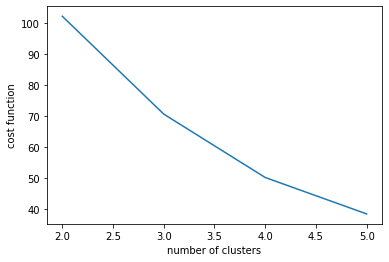

In [31]:
elbow=[]
for i in range(2,6):
    kmeans=KMeans(n_clusters=i,random_state=42,max_iter=50)
    kmeans.fit(scaled_df2)
    elbow.append(kmeans.inertia_)
sns.lineplot(x=range(2,6),y=elbow)
plt.xlabel('number of clusters')
plt.ylabel('cost function')

as per above plot 4 is the optimal number of clusters. <br>
lets check sihoutte method also

## checking silhoutte method

In [35]:
for i in range(2,7):
    kmeans=KMeans(n_clusters=i,random_state=42,max_iter=50)
    kmeans.fit(scaled_df2)
    sil_avg=silhouette_score(scaled_df2,kmeans.labels_)
    print("For n_clusters={0}, the silhouette score is {1}".format(i, sil_avg))

For n_clusters=2, the silhouette score is 0.37632823237612395
For n_clusters=3, the silhouette score is 0.37185804193936567
For n_clusters=4, the silhouette score is 0.3836904829421138
For n_clusters=5, the silhouette score is 0.36941231708738775
For n_clusters=6, the silhouette score is 0.37992910667909674


as per silhoute method also 4 is the optimal number. <br>
so we will go with 4 clusters

## building 4 clusters 

In [36]:
kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(scaled_df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## assigning the labels to df

In [37]:
df1['labels']=kmeans.labels_
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Player,Ave,SR,labels
0,SR Tendulkar (INDIA),44.83,86.23,1
1,KC Sangakkara (Asia/ICC/SL),41.98,78.86,2
2,RT Ponting (AUS/ICC),42.03,80.39,2
3,ST Jayasuriya (Asia/SL),32.36,91.20,3
4,DPMD Jayawardene (Asia/SL),33.37,78.96,0


# analysing the clusters

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


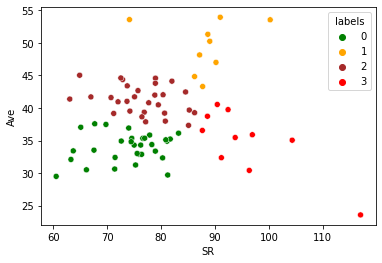

In [40]:
sns.scatterplot(df1['SR'],df1['Ave'],hue=df1['labels'],palette=['green','orange','brown','red'])

## observations from the above scatter plot
* label 0 $\rightarrow$ Low average and low strike rate
* label 1 $\rightarrow$ High average and High strike rate
* label 2 $\rightarrow$ High average and low strike rate
- label 3 $\rightarrow$ Low average and High strike rate

checking High average and High strike rate group

In [41]:
df1['Player'][df1['labels']==1]

0        SR Tendulkar (INDIA)
13      MS Dhoni (Asia/INDIA)
15    AB de Villiers (Afr/SA)
25            V Kohli (INDIA)
34               HM Amla (SA)
38             MG Bevan (AUS)
42          IVA Richards (WI)
63            MJ Guptill (NZ)
64           MEK Hussey (AUS)
Name: Player, dtype: object